In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('data_decomposed.csv')

In [2]:
from sklearn import metrics
def print_metrics(pred, y_vals):
    print('mape: ', metrics.mean_absolute_percentage_error(y_vals, pred))
    print('mae: ', metrics.mean_absolute_error(y_vals, pred))
    print('mse: ', metrics.mean_squared_error(y_vals, pred))
    print('rmse: ', np.sqrt(metrics.mean_squared_error(y_vals, pred)))
    print('r2: ', metrics.r2_score(y_vals, pred))
    count = 0
    y_error = pred.flatten() - y_vals.flatten()
    y_error = np.array([abs(e) for e in y_error]).flatten()
    for i in range(len(y_error)):
        if(y_error[i] < 0.15 * y_vals[i]):
            count += 1
    print('15% 准确度: ', count / len(pred))

In [3]:
import os
split_line = 5828
window = 8
predict_num = 1
y_row_list = []
for row in range(split_line-window-predict_num+1):
    y_row_list.append(dict(("y"+str(index),data["wind"][row+index+window]) for index in range(predict_num)))
y=pd.DataFrame(y_row_list)

In [4]:
from sklearn.preprocessing import StandardScaler
yscaler = StandardScaler()
y_train = yscaler.fit_transform(y.to_numpy())
pd.DataFrame(y_train)

,0
0,-0.458198
1,-0.839920
2,-0.168938
3,0.449451
4,-0.246130
...,...
5815,-1.362453
5816,-1.693278
5817,-1.415894
5818,-1.435405


In [5]:
from prophet import Prophet
filename='only_prophet_gru_wind.npy'
features = ['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms',
            'additive_terms_lower', 'additive_terms_upper', 'yhat']
if os.path.isfile(filename):
    X=np.load(filename)
else:
    X=np.empty((0,(len(features)+1)*window))
    for row in range(split_line-window-predict_num+1):
        temp_df = pd.DataFrame(data['ds'][row:row+window])
        temp_df['y'] = data['wind'][row:row+window]
        m = Prophet(changepoint_prior_scale=1.0, seasonality_prior_scale=0.1, seasonality_mode='additive', changepoint_range=1, n_changepoints=window-1)
        m.fit(temp_df)
        future = m.make_future_dataframe(periods=1, freq='3H')
        forecast = m.predict(future)
        forecast = forecast[features].to_numpy()[:-1]
        forecast = np.append(forecast, np.array([data['wind'][row+i] for i in range(window)]).reshape(-1,1), axis=1)
        forecast = forecast.flatten()
        forecast = forecast.reshape(1,-1)
        X=np.append(X, forecast, axis=0)
    np.save(filename, X)
X

array([[ 2.18127848,  0.4874593 ,  4.04200566, ...,  0.        ,
         2.95564318,  5.1519966 ],
       [ 1.81760196, -0.19908855,  3.59348893, ...,  0.        ,
         2.94914557,  2.963997  ],
       [ 1.53029854, -0.3122816 ,  3.09903706, ...,  0.        ,
         2.98501904,  2.0639954 ],
       ...,
       [ 4.503998  ,  4.503998  ,  4.503998  , ...,  0.        ,
         0.05199814,  0.05199814],
       [ 4.3399963 ,  4.3399963 ,  4.3399963 , ...,  0.        ,
         0.70599747,  0.70599747],
       [ 5.8999977 ,  5.8999977 ,  5.8999977 , ...,  0.        ,
         0.65999603,  0.65999603]])

In [6]:
X.shape

(5820, 80)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
from sklearn.decomposition import KernelPCA
pca = KernelPCA(kernel='rbf')
X_train = pca.fit_transform(X_train)
X_train.shape

(5820, 5819)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train.shape

(5820, 1, 5819)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 1024)           21027840  
                                                                 
 gru_1 (GRU)                 (None, 1, 512)            2362368   
                                                                 
 dense (Dense)               (None, 1, 1)              513       
                                                                 
Total params: 23,390,721
Trainable params: 23,390,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
182/182 [==============================] - 53s 245ms/step - loss: 0.2312
Epoch 2/10
182/182 [==============================] - 44s 243ms/step - loss: 0.1924
Epoch 3/10
182/182 [==============================] - 44s 243ms/step - loss: 0.1807
Epoch 4/10
182/182 [==============================] - 44

<IPython.core.display.Javascript object>


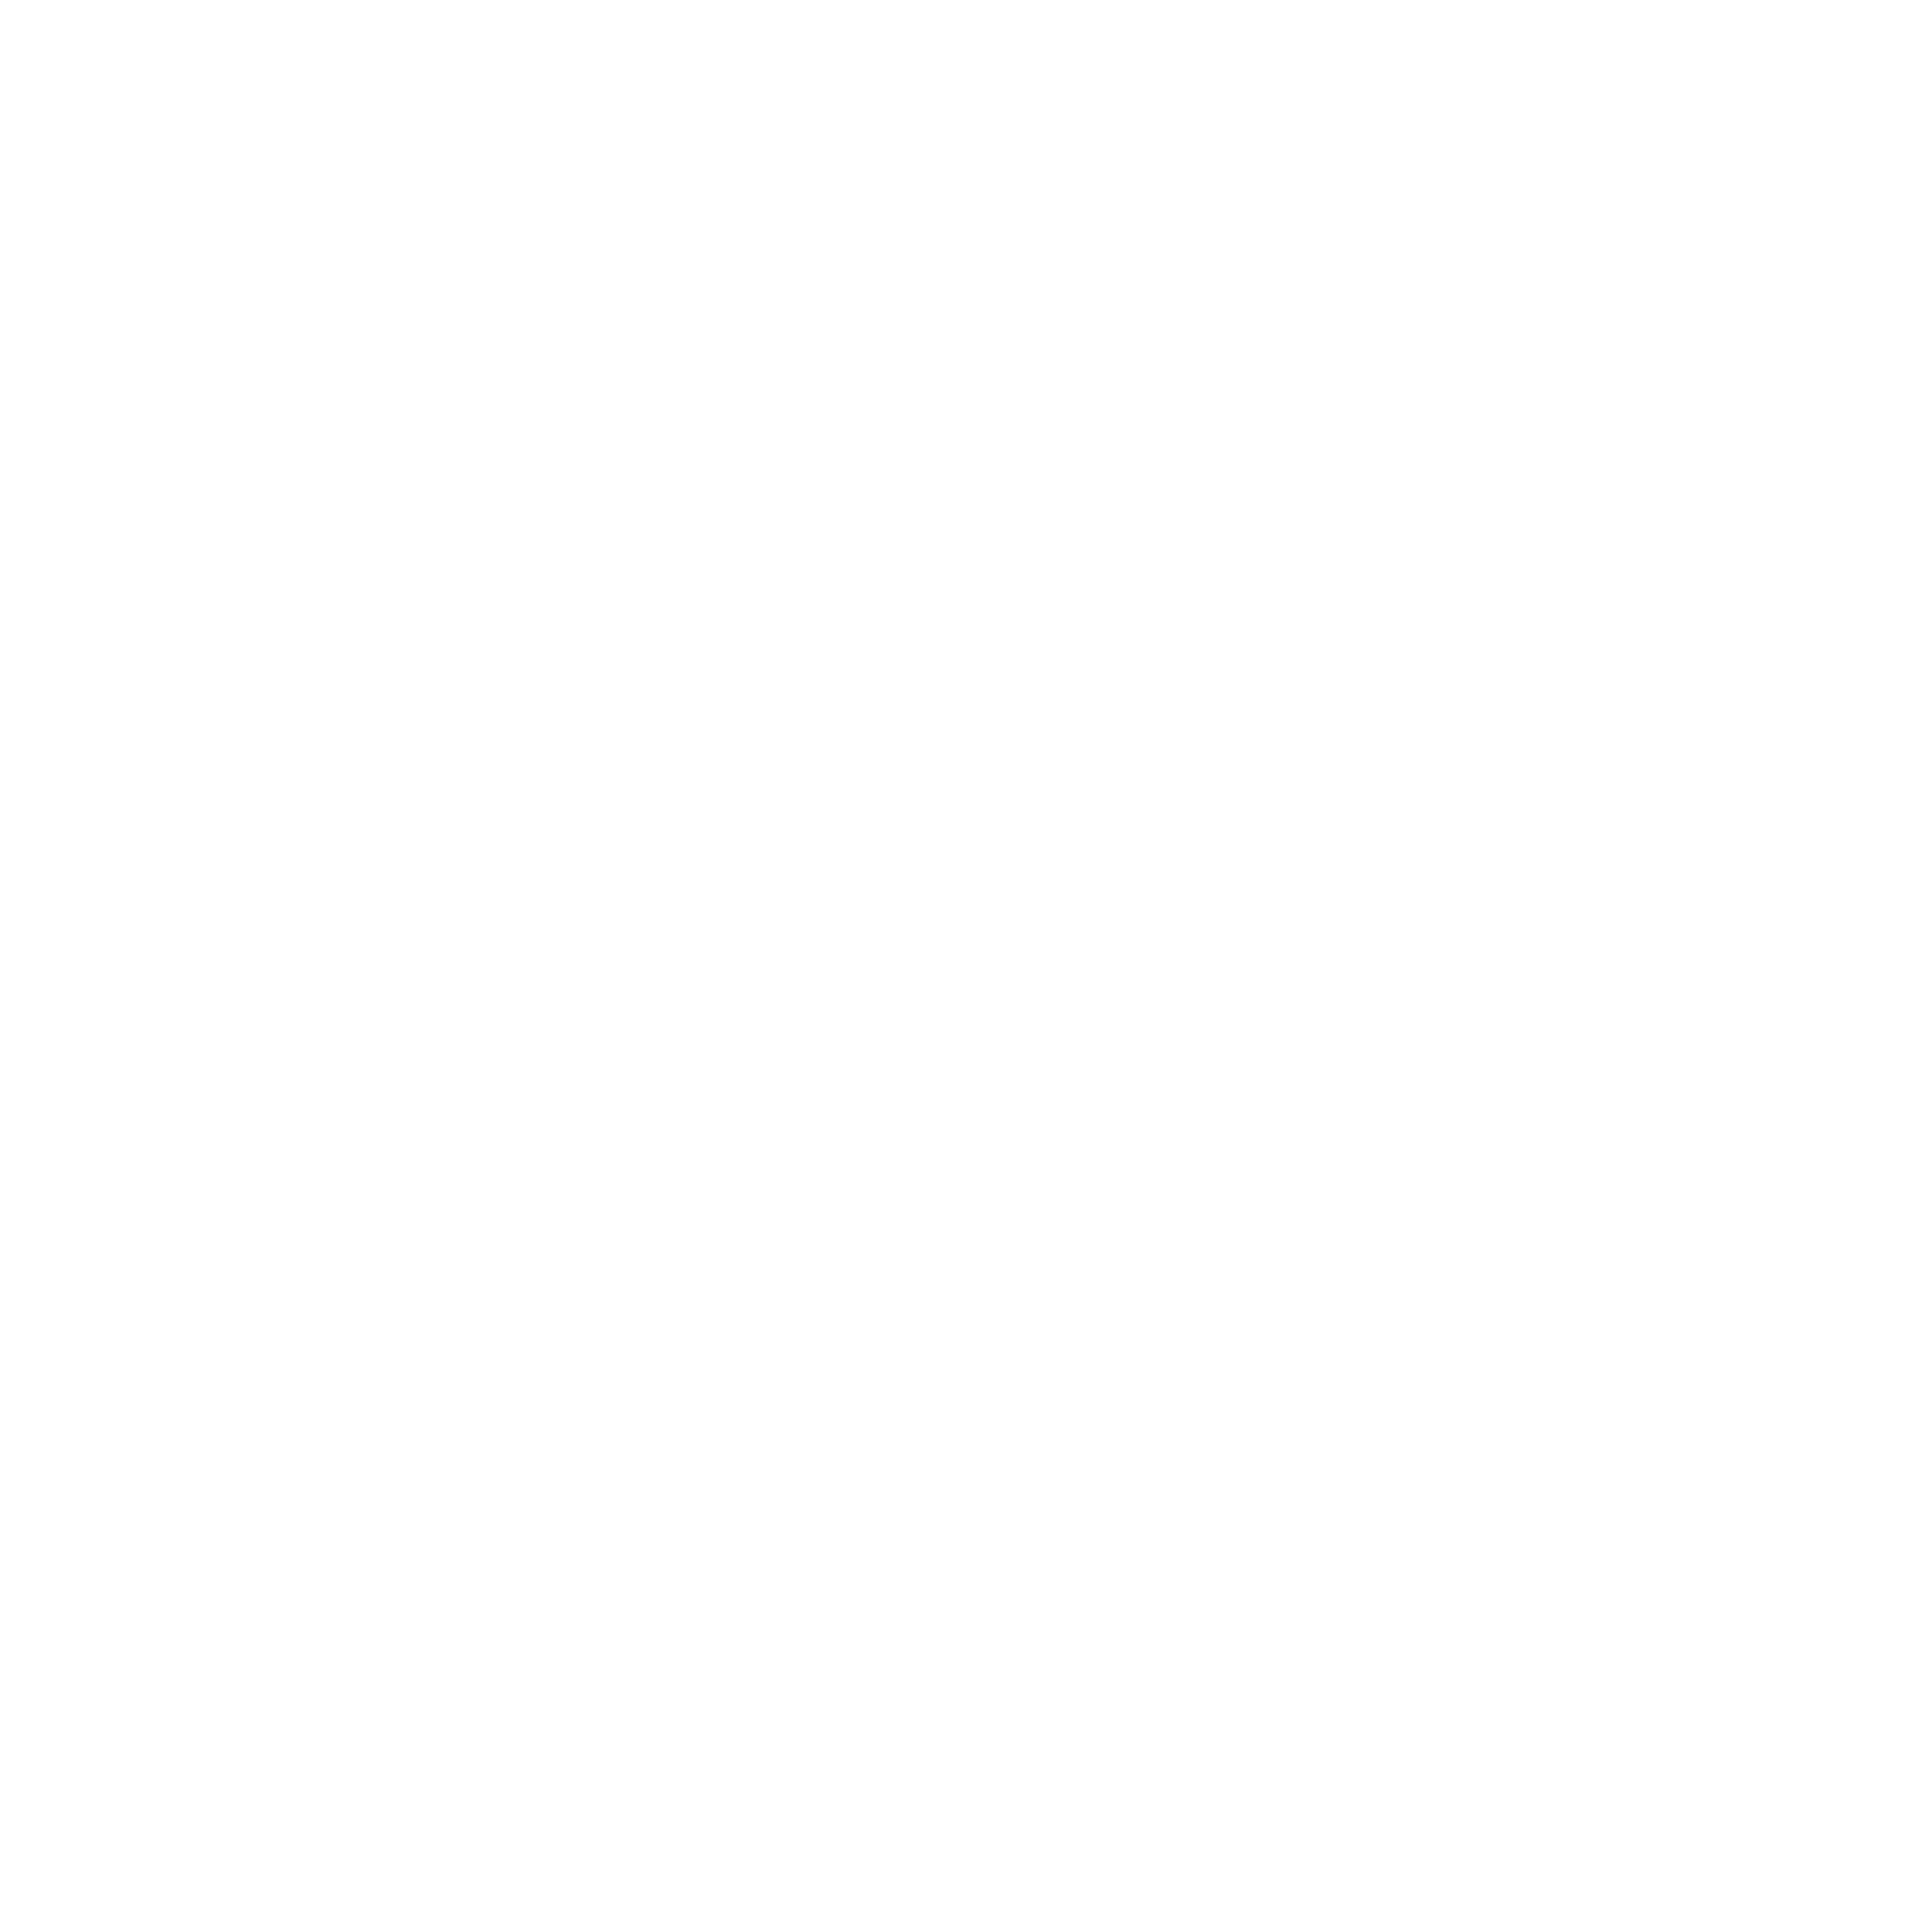

In [9]:
from tensorflow import keras
modelname='wind_only_prophet_gru'
if os.path.isdir(modelname):
    model = keras.models.load(modelname)
else:
    model = keras.models.Sequential()
    model.add(keras.layers.GRU(1024,input_shape = (predict_num, X_train.shape[2]),return_sequences = True))
    model.add(keras.layers.GRU(512,activation = 'gelu', recurrent_activation = 'gelu',return_sequences = True))
    model.add(keras.layers.Dense(predict_num))
    es_callback = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, monitor="loss")
    model.compile(loss = keras.losses.Huber(), optimizer = keras.optimizers.Nadam(0.001))
    model.summary()
    keras.utils.plot_model(model, to_file=modelname+'model_plot.pdf', show_shapes=True, show_layer_names=True)
    history=model.fit(X_train, y_train, epochs = 10, verbose = 1, shuffle = True, callbacks = [es_callback])
    import matplotlib.pyplot as plt
    %matplotlib notebook
    plt.rcParams['font.size']=64
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    pic = plt.figure(figsize=(32,32))
    plt.plot(history.history['loss'])
    plt.title(u'仅使用风速历史的GRU模型训练损失变化')
    plt.xlabel(u'Epoch')
    plt.ylabel(u'损失')
    pic.savefig(modelname + "_training_loss.pdf")
#     model.save(modelname)

In [10]:
predicted = yscaler.inverse_transform(model.predict(X_train)).flatten()
predicted[predicted < 0] = 0
row_list = y_row_list.copy()
for pointer in range(X.shape[0],len(data)-split_line+X.shape[0]):
    input_np = np.array([row_list[row]['y0'] for row in range(pointer-window, pointer)])
    temp_df = pd.DataFrame(data['ds'][pointer:pointer+window])
    temp_df['y'] = input_np
    m = Prophet(changepoint_prior_scale=1.0, seasonality_prior_scale=0.1, seasonality_mode='additive', changepoint_range=1, n_changepoints=window-1)
    m.fit(temp_df)
    future = m.make_future_dataframe(periods=1, freq='3H')
    forecast = m.predict(future)
    forecast = forecast[features].to_numpy()[:-1]
    forecast = np.append(forecast, np.array([row_list[row]['y0'] for row in range(pointer-window, pointer)]).reshape(-1,1), axis=1)
    input_np = forecast.flatten()
    input_np = scaler.transform(input_np.reshape(1, -1))
    input_np = pca.transform(input_np)
    input_np = np.reshape(input_np, (input_np.shape[0], 1, input_np.shape[1]))
    row_list.append(dict(("y"+str(index),yscaler.inverse_transform(model.predict(input_np))[0][index][0]) for index in range(predict_num)))

predictions = pd.DataFrame(row_list)[X.shape[0]:]
predictions[predictions < 0] = 0

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to o

In [11]:
y_train = y.to_numpy()

In [12]:
print_metrics(predicted, y_train)

mape:  0.43295025128245
mae:  0.8805802302548965
mse:  1.4943840504481436
rmse:  1.2224500196114947
r2:  0.7311745807374688
15% 准确度:  0.43470790378006874


In [13]:
print_metrics(predictions.to_numpy(), data["wind"][split_line:].to_numpy())

mape:  0.13559188782679185
mae:  0.28601252985076897
mse:  0.11218618011355244
rmse:  0.33494205485957185
r2:  0.3051941488779586
15% 准确度:  0.5


In [14]:
generated = pd.DataFrame(data['ds'])[window:]
generated['y_pred'] = np.append(predicted, predictions)
generated['y_real'] = np.array(pd.DataFrame(data['wind'])[window:])
generated.to_csv(modelname + ".csv")

<IPython.core.display.Javascript object>


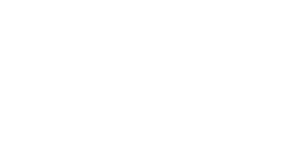

In [15]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['font.size']=64
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fore_line=4100
end_line=4200
pic = plt.figure(figsize=(32,32))
plt.plot(y_train[fore_line:end_line],'g',predicted[fore_line:end_line],'r')
plt.title('仅使用风速历史的Prophet-GRU模型训练集拟合')
plt.plot(y_train[fore_line:end_line],'g',label=u'真实值')
plt.plot(predicted[fore_line:end_line],'r',label=u'预测值')
plt.xlabel(u'时间（3小时）')
plt.ylabel(u'近地面全风速（m/s）')
plt.legend()
pic.savefig(modelname + "_predict_train.pdf")

<IPython.core.display.Javascript object>


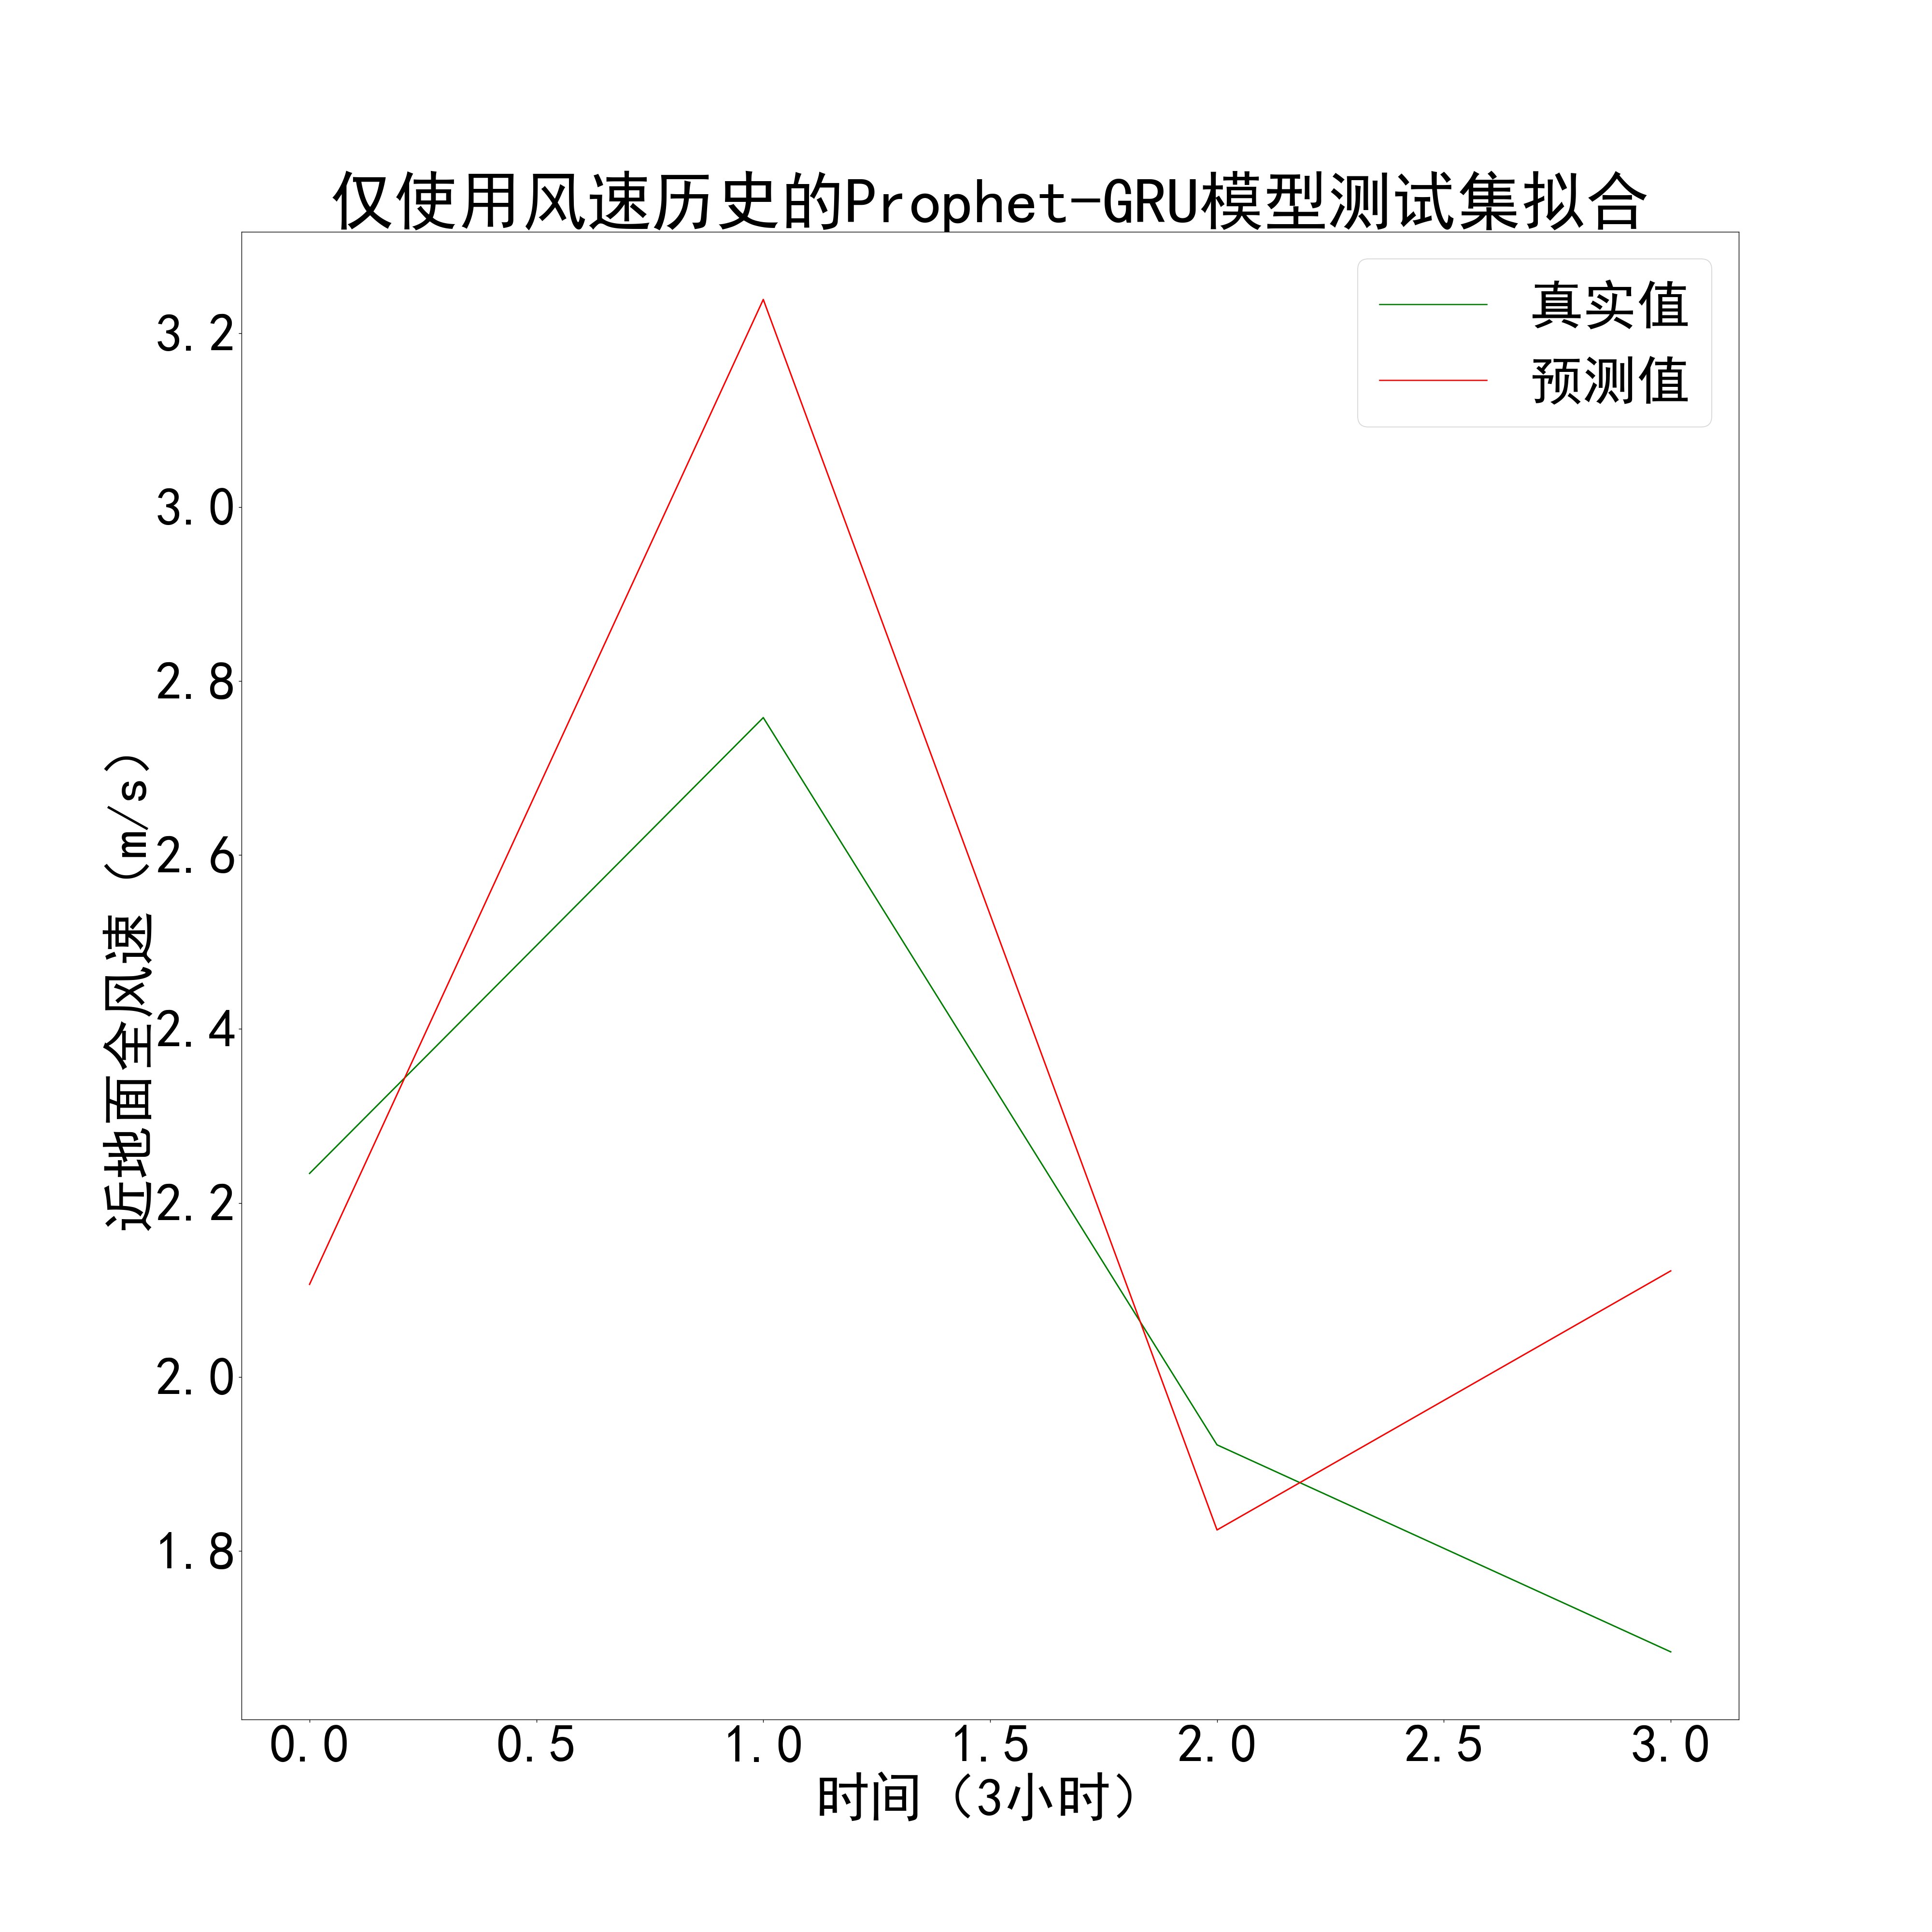

In [16]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['font.size']=64
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

pic = plt.figure(figsize=(32,32))
plt.plot(data["wind"][split_line:].to_numpy(),'g',predictions.to_numpy(),'r')
plt.title('仅使用风速历史的Prophet-GRU模型测试集拟合')
plt.plot(data["wind"][split_line:].to_numpy(),'g',label=u'真实值')
plt.plot(predictions.to_numpy(),'r',label=u'预测值')
plt.xlabel(u'时间（3小时）')
plt.ylabel(u'近地面全风速（m/s）')
plt.legend()
pic.savefig(modelname + "_predict_test.pdf")